<a href="https://colab.research.google.com/github/Dushanthimadhushika3/Customer-Segmentation-using-RFM-Model-KMean-Algorithm/blob/main/Customer_Segmentation_using_RFM_Model_%26_KMean_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install pyspark

In [24]:
# import modules
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import glob

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("Colab")\
        .config('spark.ui.port', '4050').getOrCreate()

In [25]:
#load data
csv = glob.glob('/content/drive/MyDrive/L4S1/Big Data/Data/Datasets'+'/*.csv')

# Read the data from the dataset
# create Pandas dataframes and add the column "month"
frame=[]
for f in csv:
  df = pd.read_csv(f)
  df['month']=f[-7:-4]
  frame.append(df)
df_out=pd.concat(frame,ignore_index=True,sort=False)
        
# a quick examination of the dataframe
print("The dataframe has {} rows and {} columns.\n".format(df.shape[0],df.shape[1]))
print("Shown below are the first 3 rows of the dataframe:\n")
pd.set_option('display.max_columns', 100)
display(df_out.head(3))

The dataframe has 3533286 rows and 10 columns.

Shown below are the first 3 rows of the dataframe:



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month
0,2020-01-01 00:00:00 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,Jan
1,2020-01-01 00:00:09 UTC,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a,Jan
2,2020-01-01 00:00:19 UTC,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,Jan


In [26]:
# data preparation

# step 1: select customers who purchased
sales=df_out.loc[df_out['event_type']=='purchase']

# step 2: drop "category_code", "brand", "product_id", "category_id", and "user_session"
sales=sales.drop(columns=['category_code','brand','product_id','category_id','user_session'])

# step 3: drop duplicates
sales=sales.drop_duplicates()

# step 4: convert "event_time" to DateTime format
sales['event_time']=pd.to_datetime(sales['event_time'],infer_datetime_format=True)

sales.head(3)

,event_time,event_type,price,user_id,month
60,2020-01-01 00:06:07+00:00,purchase,2.16,595411904,Jan
61,2020-01-01 00:06:07+00:00,purchase,7.92,595411904,Jan
590,2020-01-01 00:51:38+00:00,purchase,14.51,595351517,Jan


In [27]:
# group the data by "user_id", and calcualte each customer's recency, frequency, and monetary value

# step 1: calculate "Recency", set Feb 2020 as the reference month, and use "month" as the unit
d={"Oct":4,"Nov":3,"Dec":2,"Jan":1,"Feb":0}

sales.loc[:,'Recency']=sales['month'].map(d)
df_R=sales.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})

# step 2: calculate "Frequency"
df_F=sales.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})

# step 3: calculate "Monetary"
df_M=sales.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})

# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')

# step 5: remove outliers before K-Means clustering
conditions=np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_RFM2=df_RFM.loc[conditions,:]

df_RFM2.head(3)

,user_id,Recency,Frequency,Monetary
0,9794320,3,2,7.72
1,10079204,3,2,25.81
2,10280338,0,19,63.29


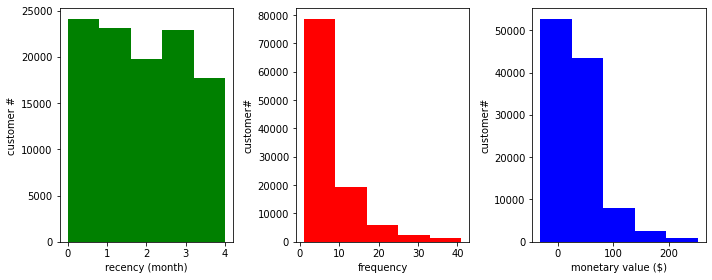

In [28]:
# visualize the distribution of "Recency", "Frequency", and "Monetary"
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,4))

# plot "Recency"
ax1.hist(df_RFM2['Recency'],bins=5,color='green')
ax1.set_xticks(np.arange(0,5,1))
ax1.set_xlabel('recency (month)')
ax1.set_ylabel('customer #')

# plot "Frequency"
ax2.hist(df_RFM2['Frequency'],bins=5,color='red')
ax2.set_xlabel('frequency')
ax2.set_ylabel('customer#')

# plot "Monetary"
ax3.hist(df_RFM2['Monetary'],bins=5,color='blue')
ax3.set_xlabel('monetary value ($)')
ax3.set_ylabel('customer#')

plt.tight_layout()

In [29]:
FEATURES_COL = ["Recency","Frequency","Monetary"]#defining the features column
df_spark = spark.createDataFrame(df_RFM2)
for col in df_spark.columns:
    if col in FEATURES_COL:
        df_spark = df_spark.withColumn(col,df_spark[col].cast('float'))
df_spark.show(3)

+--------+-------+---------+--------+
| user_id|Recency|Frequency|Monetary|
+--------+-------+---------+--------+
| 9794320|    3.0|      2.0|    7.72|
|10079204|    3.0|      2.0|   25.81|
|10280338|    0.0|     19.0|   63.29|
+--------+-------+---------+--------+
only showing top 3 rows



In [30]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df_spark).select('user_id',"features")
df_kmeans.show(5)

+--------+--------------------+
| user_id|            features|
+--------+--------------------+
| 9794320|[3.0,2.0,7.719999...|
|10079204|[3.0,2.0,25.80999...|
|10280338|[0.0,19.0,63.2900...|
|12055855|[2.0,4.0,16.54000...|
|12936739|[1.0,2.0,29.88999...|
+--------+--------------------+
only showing top 5 rows



In [31]:
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=8))
    cost[k] = model.summary.trainingCost

Text(0, 0.5, 'cost')

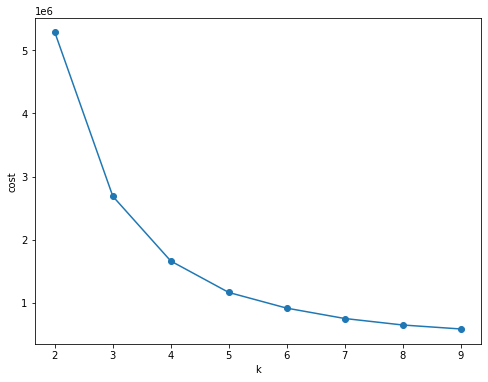

In [32]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),cost[2:10],marker='o')
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [33]:
k = 4#no.of clusters
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()#center values of the clusters
ctr=[]
print("Cluster Centers: ")
for center in centers:
    print(center)
x = np.vstack(centers)

Cluster Centers: 
[ 1.98784279  3.75620132 15.61702026]
[ 1.86800038  8.40215692 45.57375516]
[  1.2719346   21.97901907 176.93685556]
[ 1.54196327 15.58107039 94.57947449]


In [34]:
transformed = model.transform(df_kmeans).select('user_id', 'prediction')
rows = transformed.collect()

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(model.transform(df_kmeans))
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7400115319317995


In [35]:
df_pred = spark.createDataFrame(rows)
df_pred.show(5)

+--------+----------+
| user_id|prediction|
+--------+----------+
| 9794320|         0|
|10079204|         0|
|10280338|         1|
|12055855|         0|
|12936739|         0|
+--------+----------+
only showing top 5 rows



In [36]:
df_pred = df_pred.join(df_spark, 'user_id')
df_pred.show(3)

+---------+----------+-------+---------+--------+
|  user_id|prediction|Recency|Frequency|Monetary|
+---------+----------+-------+---------+--------+
|203305249|         1|    3.0|     10.0|   51.72|
|231644022|         1|    2.0|      3.0|   32.39|
|235403558|         2|    3.0|     11.0|  245.58|
+---------+----------+-------+---------+--------+
only showing top 3 rows



In [37]:
df_pandas = df_pred.toPandas()
#df_pandas=df_pandas.loc[df_pandas["prediction"]==0,'Recency']
df_pandas.head(3)

,user_id,prediction,Recency,Frequency,Monetary
0,203305249,1,3.0,10.0,51.720001
1,231644022,1,2.0,3.0,32.389999
2,235403558,2,3.0,11.0,245.580002


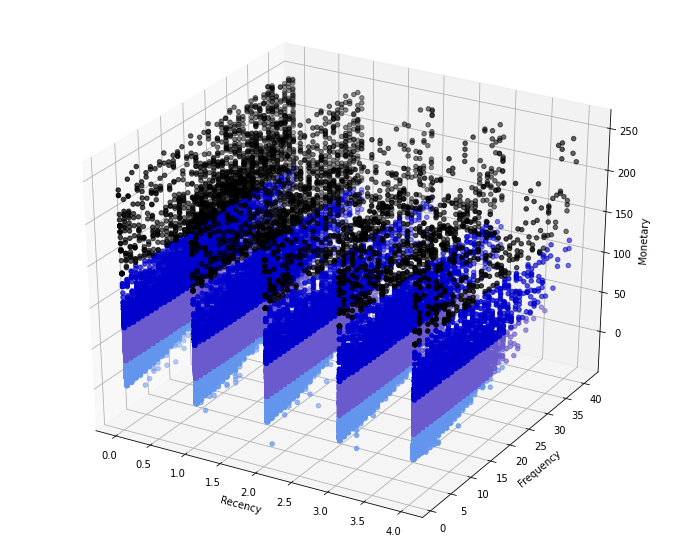

In [39]:
graph = plt.figure(figsize=(12,10)).gca(projection='3d')
r=[]
f=[]
m=[]
colors = ['cornflowerblue','slateblue','black','mediumblue']

for i in [0,1,2,3]:
  r.append(df_pandas.loc[df_pandas["prediction"]==i,'Recency'].values.tolist())
  f.append(df_pandas.loc[df_pandas["prediction"]==i,'Frequency'].values.tolist())
  m.append(df_pandas.loc[df_pandas["prediction"]==i,'Monetary'].values.tolist())
  
for i in [0,1,2,3]:
  graph.scatter(r[i],f[i],m[i],c=colors[i])

graph.set_xlabel('Recency')
graph.set_ylabel('Frequency')
graph.set_zlabel('Monetary')
plt.show()

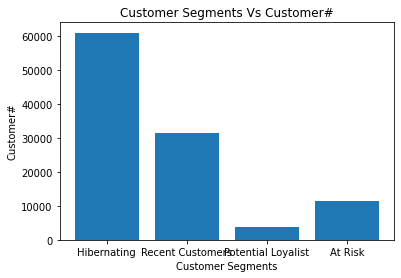

In [40]:
seg=df_pandas.groupby('prediction').size().to_frame().rename(columns={0:'number of customers'}).reset_index()
seg_names=['Hibernating','Recent Customers','Potential Loyalist','At Risk']
count = []
for i in [0,1,2,3]:
    number=int(seg.loc[seg.prediction==i,'number of customers'])
    count.append(number)

plt.bar(seg_names, count)
plt.title('Customer Segments Vs Customer#')
plt.xlabel('Customer Segments')
plt.ylabel('Customer#')
plt.show()